In [39]:
from time import time, sleep
from datetime import date

from requests import get
import json

from multiprocessing.pool import ThreadPool as Pool

import haversine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def vehicle_df_creator(vehicles):
    
    vehicles_df = pd.DataFrame(vehicles['list']).drop(['stale', 'serviceDate', 'stopSequence', 'lastUpdateTime', 'status', 'congestionLevel', 'bearing', 'capacity', 'stopDistancePercent', 'wheelchairAccessible', 'style', 'deviated'], 1)
    vehicles_df = pd.concat([vehicles_df, pd.json_normalize(vehicles_df['location'])], 1)

    vehicles_df = vehicles_df.merge(routes, left_on = 'routeId', right_on = 'id', how = 'left')
    vehicles_df = vehicles_df.merge(stops_df[['id', 'name']], left_on = 'stopId', right_on = 'id', how = 'left')

    vehicles_df.drop(['location', 'type', 'routeId', 'stopId', 'id_x', 'id_y'], 1, inplace = True)
    vehicles_df.rename(columns = {'name' : 'Megálló'}, inplace = True)

    return vehicles_df

def plot_MOL_Bubi_dist():
    
    plt.figure()
    sns.displot(data = bikes_data, x = 'bikes', color = '#89bedc', height = 4, aspect = 2, bins = 15)

    plt.title('Elérhető MOL Bubi biciklik')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

def plot_MOL_bubi():
    
    bikes_data['size_for_plot'] = bikes_data['bikes'] + 1

    fig = px.scatter_mapbox(bikes_data, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'bikes'],
                            title = 'MOL Bubi bicikli-állomások és szabad biciklik száma',
                            zoom = 10.9, size_max = 12, size = 'size_for_plot', 
                            mapbox_style = 'carto-positron', width = 750)
    fig.show()

    bikes_data.drop('size_for_plot', 1, inplace = True)
    
    
def plot_STOP_TYPES():
    
    order = megallok.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = megallok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Megálló típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 4900)
    plt.ylabel(None)
    plt.show()
    
def plot_gyujtok_map():

    fig = px.scatter_mapbox(gyujto_stop_count, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'stop_count'],
                            title = 'BKK gyűjtőállomások elhelyezkedése',
                            labels = {'name' : 'Név', 'stop_count' : 'Megállók száma'},
                            zoom = 10, size_max = 15, size = 'stop_count', 
                            mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    
def plot_stops_map():
    
    megallok['size'] = 1

    fig = px.scatter_mapbox(megallok, lat = 'lat', lon = 'lon', hover_name = 'name',
                            hover_data = ['name', 'routeIds', 'direction'],
                            title = 'BKK megállók és állomások elhelyezkedése', size = 'size', size_max = 4,
                            labels = {'name' : 'Név', 'routeIds' : 'Útvonalak', 'direction' : 'Irány'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 750, width = 1050)
    fig.show()
    
    megallok.drop('size', 1, inplace = True)
    
    
def plot_ROUTE_TYPES():
    
    order = routes.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = routes, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Útvonal típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 350)
    plt.ylabel(None)
    plt.show()
    
    
def plot_CELALLOMAS():
    
    plt.figure(figsize = (9, 7))
    ax = sns.barplot(y = 'name', x = 'Útvonal végállomása', data = celallomasok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Vég- és kiinduló-állomások')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()
    
def plot_vehicles_map():
    
    vehicles_df['size'] = 1

    fig = px.scatter_mapbox(vehicles_df, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Aktuális járművek', size = 'size', size_max = 4.5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = 'vehicleRouteType', 
                            color_discrete_map = {'BUS' : 'blue', 'TRAM' : 'yellow', 'TROLLEYBUS' : 'red', 'SUBURBAN_RAILWAY' : 'green'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 750, width = 1050)
    fig.show()
    
    vehicles_df.drop('size', 1, inplace = True)
    
    
def plot_VEHICLES_TYPES():
    
    order = vehicles_df['vehicleRouteType'].value_counts()
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'vehicleRouteType', data = vehicles_df, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Aktív járművek típusai')
    plt.xlabel(None)
    plt.xlim(0, vehicles_df['vehicleRouteType'].value_counts().max() + 75)
    plt.ylabel(None)
    plt.show()
    
    
def plot_BUS_TYPE(filter_type = 'ikarus'):
    
    vehicles_df_buses = vehicles_df[vehicles_df['vehicleRouteType'] == 'BUS'].copy()
    
    vehicles_df_buses[filter_type] = 0
    vehicles_df_buses.loc[vehicles_df_buses['model'].str.lower().str.contains(filter_type), filter_type] = 1
    vehicles_df_buses[filter_type] = vehicles_df_buses[filter_type].astype(str)
    
    vehicles_df_buses['size'] = 1

    fig = px.scatter_mapbox(vehicles_df_buses, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Busztípusok elhelyezkedése - ' + filter_type, size = 'size', size_max = 5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = filter_type, 
                            color_discrete_map = {'0': 'lightgreen', '1' : 'brown'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 750, width = 1050)
    fig.show()
    
    vehicles_df_buses.drop('size', 1, inplace = True)
    
    
def get_trip_details(i):
    
    trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + i + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
    trip_data = get(trip_link, headers = headers, verify = False).json()
    
    if 'data' in trip_data.keys():
        trip_data = trip_data['data']
        
        trip_id = i
    
        if 'vehicle' in trip_data['entry'].keys():
            route_id = trip_data['entry']['vehicle']['routeId']    
        else:
            route_id = np.nan

        if 'stopSequence' in trip_data['entry']['stopTimes'][-1].keys():
            stops_num = trip_data['entry']['stopTimes'][-1]['stopSequence']
        else:
            stops_num = np.nan

        if 'shapeDistTraveled' in trip_data['entry']['stopTimes'][-1].keys():
            dist = trip_data['entry']['stopTimes'][-1]['shapeDistTraveled']
        else:
            dist = np.nan

        trip_dict = {'id' : route_id, 'tripId' : trip_id, 'num_of_stops' : stops_num, 'total_distance' : dist}

        return trip_dict
    
    else:
        pass 
    
    
BOXPLOT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth' : 1},
    'flierprops':{'markerfacecolor':'black', 'markeredgecolor':'darkgray', 'marker' : 'x'},
    'medianprops':{'color':'black', 'linewidth' : 1},
    'whiskerprops':{'color':'black', 'linewidth' : 1},
    'capprops':{'color':'black', 'linewidth' : 1}
}

def boxplot_sns(data, x, y):  
    
    order = data.groupby([x]).median().sort_values(y, ascending = False)

    plt.figure(figsize = (8, 4))
    sns.boxplot(data = data, y = x, x = y, color = 'blue', fliersize = 2, 
                **BOXPLOT_PROPS, order = order.index)
    plt.xlabel(y)
    plt.ylabel(None)
    plt.title('Járműtípusonkénti eloszlások\n')
    plt.show()

In [3]:
%%time

headers = {'User-agent' : 'Mozilla/5.0 (Windows; U; Windows NT 5.1; de; rv:1.9.1.5) Gecko/20091102 Firefox/3.5.5'}

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")
lat = str(47.497913)
lon = str(19.040236)

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stops_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/stops-for-location.json?lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
bikes_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/bicycle-rental.json?key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'

stops = get(stops_link, headers = headers, verify = False).json()['data']
bikes = get(bikes_link, headers = headers, verify = False).json()['data']
sleep(1)
vehicles = get(vehicles_link, headers = headers, verify = False).json()['data']

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Wall time: 3.5 s


### Bikes

In [4]:
bikes_data = pd.DataFrame(bikes['list'])
bikes_data.drop(['type', 'spaces'], 1, inplace = True)

<Figure size 432x288 with 0 Axes>

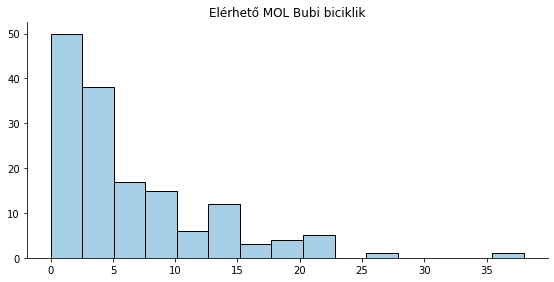

In [5]:
plot_MOL_Bubi_dist()

In [8]:
plot_MOL_bubi()

### Stops

In [9]:
stops_df = pd.DataFrame.from_dict(stops['references']['stops'], orient = 'index').reset_index(drop = True)
stops_df.drop(['description', 'style', 'wheelchairBoarding'], 1, inplace = True)
stops_df.head(3)

,id,lat,lon,name,code,direction,locationType,locationSubType,routeIds,stopColorType,parentStationId,type
0,BKK_CSF00232,47.513817,19.033945,Margit körút,CSF00232,,1,stop-area,[],OTHER,NaN,NaN
1,BKK_CSF00233,47.514609,19.033215,Apostol utca,CSF00233,,1,stop-area,[],OTHER,NaN,NaN
2,BKK_CSF01563,47.483975,19.117162,Egészségház,CSF01563,,1,stop-area,[],OTHER,NaN,NaN


In [10]:
gyujtok = stops_df[(stops_df['type'].isnull()) & 
                   (stops_df['stopColorType'] == 'OTHER') & 
                   (stops_df['locationSubType'].isin(['station', 'stop-area']))].copy()

In [11]:
megallok = stops_df[(stops_df['type'].notnull())].copy()
megallok.drop(['locationType', 'locationSubType'], 1, inplace = True)

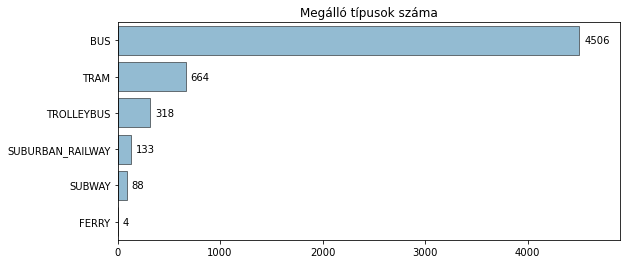

In [12]:
plot_STOP_TYPES()

In [13]:
gyujto_stop_count = megallok.groupby('parentStationId')['id'].count().reset_index().rename(columns = {'id' : 'stop_count'})
gyujto_stop_count = gyujtok[['id', 'lat', 'lon', 'name']].merge(gyujto_stop_count, left_on = 'id', right_on = 'parentStationId').drop('parentStationId', 1)

In [14]:
plot_gyujtok_map()

In [15]:
plot_stops_map()

Calculate distance matrix - find farthest from all stop, closest stops, etc... For this use the 'Gyujok' data, not the actual stops

In [ ]:
%%time

distances = []

for i, row_i in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
    
    _from_id = row_i['id']
    _from_name = row_i['name']
    _from_coord = (row_i['lat'], row_i['lon'])
    
    for j, row_j in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
        
        _to_id = row_j['id']
        _to_name = row_j['name']
        _to_coord = (row_j['lat'], row_j['lon'])

        _dist = haversine.haversine(_from_coord, _to_coord, unit = haversine.Unit.METERS)

        _dist_dict = {'from_id' : _from_id, 'to_id' : _to_id,
                      'from_name' : _from_name,  'to_name' : _to_name, 'distance' : _dist}
        distances.append(_dist_dict)

In [ ]:
%%time

distances_df = pd.DataFrame(distances)
distances_df = distances_df[distances_df['distance'] != 0]
# distances.drop_duplicates('distance', inplace = True)

In [ ]:
# distances_df.sort_values('distance', ascending = False)

10 most farthest away from each other stops

In [ ]:
farthest = distances_df.groupby('from_id')['distance'].min().sort_values().tail(10)

In [ ]:
farthes_df = distances_df[(distances_df['from_id'].isin(farthest.index) )& 
                          (distances_df['distance'].isin(farthest.values))]

farthes_df = farthes_df.drop_duplicates('from_name')
farthes_df = farthes_df.drop_duplicates('distance')
farthes_df.sort_values('distance', ascending = False)

Farthest away stops:

    - Monor - Vecsés: 13km
    - Ráckeve - Angyalisziget: 2.7km

### Routes

In [16]:
routes = pd.DataFrame.from_dict(stops['references']['routes'], orient = 'index')\
                     .reset_index(drop = True)\
                     .drop(['color', 'textColor', 'agencyId', 'iconDisplayType', 'iconDisplayText', 'style', 'sortOrder', 'bikesAllowed'], 1)

# potlok = routes[routes['id'].str.contains('VP|HP|MP')]
# potlok kiszurese
# routes = routes[~routes['id'].str.contains('VP|HP|MP')]

routes[['From', 'To']] = routes['description'].str.split('|', expand = True)

routes['To'] = routes['To'].str.strip()
routes['From'] = routes['From'].str.strip()

routes.drop(['description'], 1, inplace = True)

routes.head(3)

,id,shortName,type,From,To
0,BKK_9960,996,BUS,Cinkotai autóbuszgarázs,Újpest-központ M
1,BKK_9720,972,BUS,"Törökbálint, Nyár utca",Móricz Zs. körtér M
2,BKK_9961,996A,BUS,Cinkotai autóbuszgarázs,Újpest-központ M


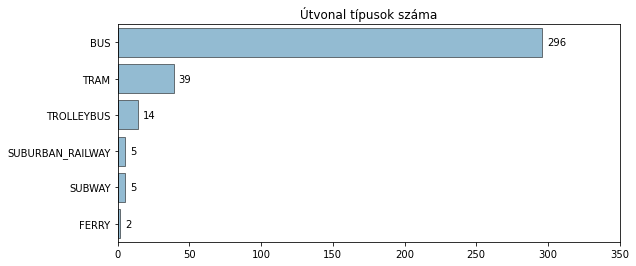

In [17]:
plot_ROUTE_TYPES()

In [18]:
celallomasok = pd.concat([routes['From'], routes['To']]).value_counts().reset_index().rename(columns = {'index' : 'name', 0 : 'Útvonal végállomása'}).head(25)
#celallomasok = stops_df[['name', 'lat', 'lon']].copy().drop_duplicates('name').merge(celallomasok, how = 'right')

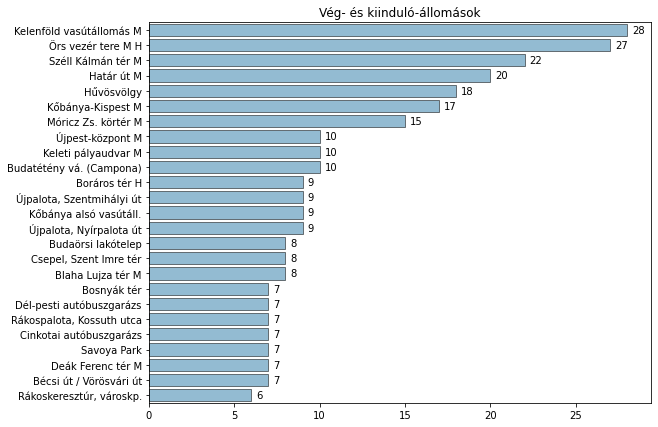

In [19]:
plot_CELALLOMAS()

### Vehicles - currently active on Map

In [20]:
vehicles_df = vehicle_df_creator(vehicles)
vehicles_df.head(3)

,vehicleId,licensePlate,label,model,vehicleRouteType,tripId,lat,lon,shortName,From,To,Megálló
0,BKK_5840,V2112,Bécsi út / Vörösvári út,CAF 9 modulos szerelvény,TRAM,BKK_C2607760,47.463726,19.032711,1,Kelenföld vasútállomás M,Bécsi út / Vörösvári út,Bikás park M
1,BKK_5601,MPW614,NaN,VanHool A330 CNG típusú szóló autóbusz,BUS,NaN,47.427730,19.157389,NaN,NaN,NaN,NaN
2,BKK_5600,MPW613,Dél-pesti autóbuszgarázs,VanHool A330 CNG típusú szóló autóbusz,BUS,BKK_C36938115,47.499725,19.287199,198,"R.csaba-Újtelep, Tóalmás u.",Dél-pesti autóbuszgarázs,"Rákoscsaba-Újtelep, Tóalmás utca"


In [21]:
print('Aktív járművek:', vehicles_df.shape[0])

Aktív járművek: 1106


In [22]:
for i in vehicles_df['vehicleRouteType'].unique():
    print(i, '- Modellek\n')
    print(vehicles_df[vehicles_df['vehicleRouteType'] == i]['model'].value_counts())
    print('\n')

TRAM - Modellek

Tátra T5C5K                  55
TW 6000                      36
CAF 5 modulos szerelvény     34
Siemens Combino              28
KCSV7 Korszerűsített Ganz    11
CAF 9 modulos szerelvény     10
Name: model, dtype: int64


BUS - Modellek

MERCEDES Conecto csuklós                    106
MAN Lions City A21 (ArrivaBus)               94
Volvo 7700A típusú csuklós autóbusz          67
MERCEDES Conecto szóló (BKV)                 61
MB Citaro C2-S1 szóló autóbusz               56
MAN A21 szóló (Volán, helyi, 3 ajtós)        47
MB Citaro C2-S1-G csuklós autóbusz           43
MERCEDES Conecto 2 szóló autóbusz            42
VanHool A330 CNG típusú szóló autóbusz       39
MERCEDES Conecto G 2 csuklós autóbusz        36
MERCEDES Citaro O 530 (BKV spec.)            31
Modulo M108d szóló autóbusz                  19
Volvo szóló autóbusz                         18
Modulo M108d szóló autóbusz (rend.tart.)     17
MERCEDES Conecto G 3 csuklós busz(Volán)     16
VanHool  NewAG300 csuklós a

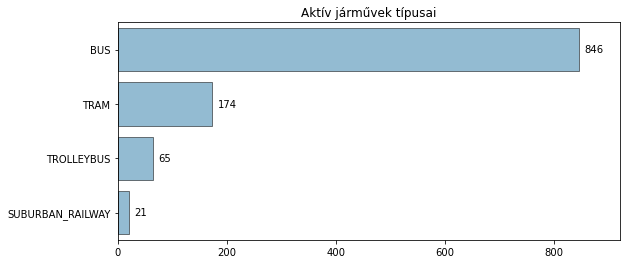

In [23]:
plot_VEHICLES_TYPES()

In [24]:
plot_vehicles_map()

In [35]:
plot_BUS_TYPE('ikarus')

### Trips - so fat can only scrape active trips - worth re running the Vehicle script before

In [40]:
%%time

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
sleep(2)
vehicles = get(vehicles_link, headers = headers, verify = False).json()['data']

vehicles_rerun = vehicle_df_creator(vehicles)

trips_list = vehicles_rerun.drop_duplicates(['vehicleRouteType', 'shortName', 'From', 'To'])['tripId'].unique().tolist()
trips_list = [i for i in trips_list if isinstance(i, float) == False]
len(trips_list)

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



Wall time: 2.77 s


216

In [41]:
%%time

trip_dicts = []

pool = Pool(4)

for i in trips_list:
    pool.apply_async(get_trip_details, (i,), callback = trip_dicts.append)

pool.close()
pool.join()

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified H

Wall time: 15.6 s


C:\Users\krist\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'futar.bkk.hu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [42]:
trips_df = pd.DataFrame([i for i in trip_dicts if i is not None])
trips_df.dropna(inplace = True)
print(trips_df.shape)

(209, 4)


In [43]:
trips_df = trips_df.merge(routes)
trips_df.head(3)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
0,BKK_3030,BKK_C30014194,31,13402.0,3,TRAM,Mexikói út M,Gubacsi út / Határ út
1,BKK_1980,BKK_C36938115,49,20254.0,198,BUS,"R.csaba-Újtelep, Tóalmás u.",Dél-pesti autóbuszgarázs
2,BKK_3010,BKK_C2607760,31,18124.0,1,TRAM,Kelenföld vasútállomás M,Bécsi út / Vörösvári út


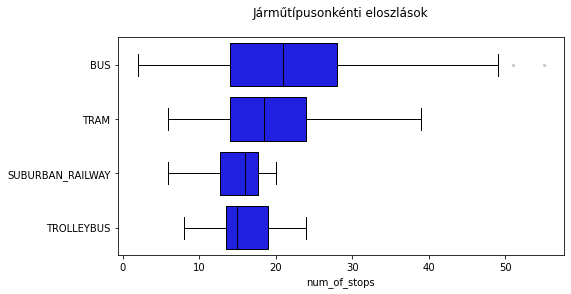

In [44]:
boxplot_sns(trips_df, 'type', 'num_of_stops')

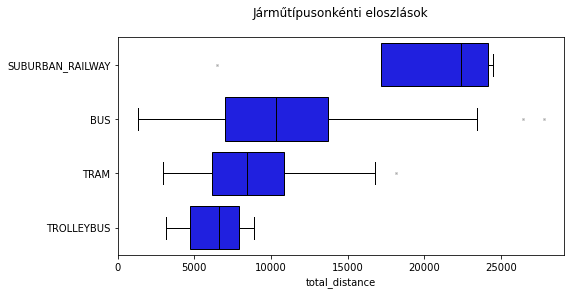

In [45]:
boxplot_sns(trips_df, 'type', 'total_distance')

Legkevesebb megálló

In [49]:
trips_df[trips_df['num_of_stops'] < 5].sort_values('num_of_stops', ascending = True)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
28,BKK_1005,BKK_C3868770,2,20789.0,100E,BUS,Liszt Ferenc Airport 2,Deák Ferenc tér M
82,BKK_VP60,BKK_C37097918,4,1316.0,60,BUS,Széchenyi-hegy,Svábhegy
146,BKK_1650,BKK_C3180192,4,1412.0,165,BUS,Remetehegyi út,Kolosy tér


Legtöbb megálló

In [47]:
trips_df[trips_df['num_of_stops'] > 40].sort_values('num_of_stops', ascending = False)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
192,BKK_0880,BKK_C27644556,55,27785.0,88,BUS,Budatétény vá. (Campona),Kelenföld vasútállomás M
43,BKK_0460,BKK_C32079521,51,23422.0,46,BUS,Helikopter lakópark,"Újpalota, Nyírpalota út"
1,BKK_1980,BKK_C36938115,49,20254.0,198,BUS,"R.csaba-Újtelep, Tóalmás u.",Dél-pesti autóbuszgarázs
62,BKK_0050,BKK_C3765592,44,18928.0,5,BUS,"Rákospalota, Kossuth utca",Pasaréti tér
53,BKK_0360,BKK_C38689299,43,18660.0,36,BUS,"Csepel, Csillagtelep",Pestszentlőrinc vasútáll.
26,BKK_0085,BKK_C34556276,41,20647.0,8E,BUS,"Újpalota, Nyírpalota út",Kelenföld vasútállomás M


Legkisebb távolság

In [50]:
trips_df[trips_df['total_distance'] < 2000].sort_values('total_distance', ascending = True)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
82,BKK_VP60,BKK_C37097918,4,1316.0,60,BUS,Széchenyi-hegy,Svábhegy
146,BKK_1650,BKK_C3180192,4,1412.0,165,BUS,Remetehegyi út,Kolosy tér
70,BKK_0161,BKK_C389433408,5,1417.0,16A,BUS,Dísz tér,Széll Kálmán tér M
80,BKK_1160,BKK_C389433440,6,1732.0,116,BUS,Dísz tér,Fény utcai piac


Legnagyobb távolság

In [51]:
trips_df[trips_df['total_distance'] > 20000].sort_values('total_distance', ascending = False)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
192,BKK_0880,BKK_C27644556,55,27785.0,88,BUS,Budatétény vá. (Campona),Kelenföld vasútállomás M
25,BKK_1335,BKK_C3860857,38,26424.0,133E,BUS,"Újpalota, Nyírpalota út","Nagytétény, Erdélyi utca"
17,BKK_H8,BKK_H10821_89,20,24472.0,H8,SUBURBAN_RAILWAY,Gödöllő,Örs vezér tere
147,BKK_H6,BKK_H213213_390,15,24055.0,H6,SUBURBAN_RAILWAY,Ráckeve,Közvágóhíd
43,BKK_0460,BKK_C32079521,51,23422.0,46,BUS,Helikopter lakópark,"Újpalota, Nyírpalota út"
174,BKK_2240,BKK_C344123,36,23144.0,224,BUS,"Újpalota, Szentmihályi út","Újpalota, Szentmihályi út"
156,BKK_2960,BKK_C38388109,40,22480.0,296,BUS,"B.megyer, Újmegyeri tér","Újpalota, Szentmihályi út"
189,BKK_1400,BKK_C3544379,39,22292.0,140,BUS,"Törökbálint, bevásárlóközp.",Széll Kálmán tér M
186,BKK_2380,BKK_C33815531,35,20860.0,238,BUS,Szigetszentmiklós,"Csepel, Szent Imre tér"
135,BKK_0380,BKK_C33815484,35,20842.0,38,BUS,Szigetszentmiklós,"Csepel, Szent Imre tér"


In [ ]:
# vehicles_df[vehicles_df['tripId'] == 'BKK_C175521046']

In [ ]:
# trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + 'BKK_1634051485889' + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
# get(trip_link, headers = headers).json()

### Stop - todo

In [ ]:
stop_id = 'BKK_F03326' # 45, Anilin --> Ors

stop_schedule_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/schedule-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
stop_vehicle_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_route_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/route-details-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_arrivals_departures_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/arrivals-and-departures-for-stop.json?includeReferences=agencies,routes,trips,stops&stopId=' + stop_id + '&minutesBefore=1&minutesAfter=30&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch


In [ ]:
# stop_schedule = get(stop_schedule_link, headers = headers).json()['data']
# [{i['routeId'] : i['directions'][0]['stopTimes']} for i in stop_schedule['entry']['schedules']]

In [ ]:
# pd.DataFrame(get(stop_vehicle_link, headers = headers).json()['data']['list'])

In [ ]:
# pd.DataFrame(get(stop_route_link, headers = headers).json()['data']['list']) # NOT NEEDED

In [ ]:
# get(stop_arrivals_departures_link, headers = headers).json()['data']['references']['trips']